In [1]:
import pandas as pd
from IPython.display import display

titanic = pd.read_csv('./input/titanic/train.csv')
display(titanic.head())

# https://www.kaggle.com/c/titanic/data
# Survived: 1 = Yes, 0 = No

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
print(titanic.Embarked.unique())
print(titanic.Embarked.isnull().sum())

['S' 'C' 'Q' nan]
2


In [3]:
df = titanic.copy()

print(df.isnull().sum())
# df_dropped = df.dropna(axis = 1)
# print(df_dropped.shape)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
df_train = df.sample(frac = 0.7, random_state = 0)
df_valid = df.drop(df_train.index)

print(df_train.shape)
print(df_valid.shape)

(624, 12)
(267, 12)


In [5]:
X_train = df_train.copy()
y_train = X_train.pop('Survived')
print(y_train.shape)
print(X_train.shape)

(624,)
(624, 11)


In [6]:
X_valid = df_valid.copy()
y_valid = X_valid.pop('Survived')
print(y_valid.shape)
print(X_valid.shape)

(267,)
(267, 11)


In [7]:
print(X_train.head(5))
print(X_train.dtypes)

     PassengerId  Pclass                                            Name  \
495          496       3                           Yousseff, Mr. Gerious   
648          649       3                              Willey, Mr. Edward   
278          279       3                              Rice, Master. Eric   
31            32       1  Spencer, Mrs. William Augustus (Marie Eugenie)   
255          256       3         Touma, Mrs. Darwis (Hanne Youssef Razi)   

        Sex   Age  SibSp  Parch         Ticket      Fare Cabin Embarked  
495    male   NaN      0      0           2627   14.4583   NaN        C  
648    male   NaN      0      0  S.O./P.P. 751    7.5500   NaN        S  
278    male   7.0      4      1         382652   29.1250   NaN        Q  
31   female   NaN      1      0       PC 17569  146.5208   B78        C  
255  female  29.0      0      2           2650   15.2458   NaN        C  
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age    

In [8]:
# Not considered:
#   PassengerId
#   Name
features_num = [
    'SibSp',
    'Parch',
    'Fare',
    'Age', # with NA, dropped before
]


features_cat = [
    'Pclass',
    'Sex',
    'Embarked',
 #   'Ticket', # Many different values
]

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(
    SimpleImputer(strategy = "constant"),
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = "NA"),
    OneHotEncoder(handle_unknown = 'ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [10]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [11]:
print(pd.DataFrame(X_train).head())
input_shape = [X_train.shape[1]]
print(input_shape)

         0         1         2         3    4    5    6    7    8    9    10  \
0 -0.499374 -0.446072 -0.338690 -1.360968  0.0  0.0  1.0  0.0  1.0  1.0  0.0   
1 -0.499374 -0.446072 -0.480245 -1.360968  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
2  3.600746  0.866894 -0.038159 -0.959403  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
3  0.525656 -0.446072  2.367362 -1.360968  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
4 -0.499374  2.179860 -0.322553  0.302661  0.0  0.0  1.0  1.0  0.0  1.0  0.0   

    11  
0  0.0  
1  1.0  
2  0.0  
3  0.0  
4  0.0  
[12]


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(16, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid'),
])

"""
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(8, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid'),
])
"""

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy'],
)

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True,
)
history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 256,
    epochs = 200,
    callbacks = [early_stopping],
    verbose = 0,
)

Maximum validation accuracy: 0.7902621626853943


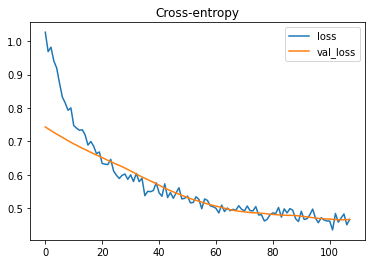

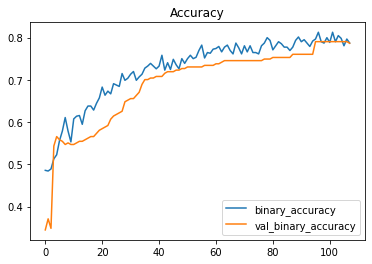

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Cross-entropy')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title = 'Accuracy')
print(f"Maximum validation accuracy: {history_df.val_binary_accuracy.max()}")

In [15]:
test = pd.read_csv('./input/titanic/test.csv')

X_test = preprocessor.fit_transform(test)

In [16]:
predictions = model.predict(X_test)
print(predictions[:5])

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': map(lambda x: 1 if x >= 0.5 else 0, predictions)})
print(output.head())

[[0.1570583 ]
 [0.438381  ]
 [0.09300303]
 [0.14117298]
 [0.34687418]]
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


In [17]:
print(model.predict(X_train[:5]))
print(y_train[:5])

[[0.17443764]
 [0.12484699]
 [0.11190069]
 [0.9170251 ]
 [0.51736206]]
495    0
648    0
278    0
31     1
255    1
Name: Survived, dtype: int64


In [18]:
output.to_csv('my_submission.csv', index=False)